In [1]:
# Libraries

import matplotlib
import numpy
import os
import pandas
import platform
import shutil
import sys
import warnings

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.data.analysis import analysis_annotation
from source.python.data.analysis import analysis_assembly
from source.python.data.analysis import analysis_metadata
from source.python.data.analysis import analysis_statistics
from source.python.data.analysis import analysis_tpm
from source.python.io            import loader
from source.python.io            import writer
from source.python               import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp00-analysis')
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_GENOME = os.path.join(RES,      'genome')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f' Resource Directory : {RES_GENOME}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp00-analysis
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\genome


In [5]:
# Load and clean (remove non-relevant columns, rename columns to same format, etc..)

data = loader.load_resources(
	directory = RES_GENOME,
	plant     = 'arabidopsis-r36',
	clean     = True
)

gene_annotation = data['gene_annotation']
gene_assembly   = data['gene_assembly']
tissue_metadata = data['tissue_metadata']
tissue_tpm      = data['tissue_tpm']

# 2. Sync

In [6]:
# Drop mt and pt sequence annotations

mt = gene_annotation[(gene_annotation['Seq'] == 'Mt') & (gene_annotation['Type'] == 'mRNA')]
pt = gene_annotation[(gene_annotation['Seq'] == 'Pt') & (gene_annotation['Type'] == 'mRNA')]

print(f'Transcript (Mt) : ' + '{:}'.format(len(mt)))
print(f'Transcript (Pt) : ' + '{:}'.format(len(pt)))
print()

gcount = gene_annotation['Gene'].nunique()
tcount = gene_annotation['Transcript'].nunique()

gene_annotation = gene_annotation[~gene_annotation['Seq'].isin(['Pt'])]
gene_annotation = gene_annotation[~gene_annotation['Seq'].isin(['Mt'])]

print('Gene       : {:} -> {:}'.format(gcount, gene_annotation['Gene'].nunique(dropna = True)))
print('Transcript : {:} -> {:}'.format(tcount, gene_annotation['Transcript'].nunique(dropna = True)))

Transcript (Mt) : 120
Transcript (Pt) : 88

Gene       : 27628 -> 27420
Transcript : 48321 -> 48113


In [7]:
# Check for sample matching between tpm and metadata tables

x = set(tissue_metadata['Sample'].dropna())
y = set(tissue_tpm.columns[1:].dropna())

sample_i = list(x.intersection(y))
sample_x = list(x.difference(y))
sample_y = list(y.difference(x))

print(f'Samples in <tissue-metadata> : {len(sample_i)} / {len(x)}')
print(f'Samples in <tissue-tpm>      : {len(sample_i)} / {len(y)}')
print()
print(f'Samples missing in <tissue-metadata> : [{len(sample_y)}] ' + ' '.join(sample_y[:5]) + (' ...' if len(sample_y) > 5 else ''))
print(f'Samples missing in <tissue-tpm>      : [{len(sample_x)}] ' + ' '.join(sample_x[:5]) + (' ...' if len(sample_x) > 5 else ''))

if len(sample_x) > 0 :
	tissue_metadata = tissue_metadata[~tissue_metadata['Sample'].isin(sample_x)]

if len(sample_y) > 0 :
	tissue_tpm = tissue_tpm.drop(columns = sample_y)

Samples in <tissue-metadata> : 4138 / 4139
Samples in <tissue-tpm>      : 4138 / 4146

Samples missing in <tissue-metadata> : [8] SRR5591030 SRR5591022 SRR5591023 SRR5591021 SRR5591033 ...
Samples missing in <tissue-tpm>      : [1] DRR273449


# 3. Data

## 3.1 Gene Annotation

In [8]:
# Show the first few gene annotations

analysis_annotation.show(gene_annotation)

Number of rows : 438629
Number of cols : 10


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
2,1,+,mRNA,AT1G01010,AT1G01010.1,NaN,AT1G01010,3631,5899,2268
3,1,+,UTR5,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3631,3759,128
5,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3760,3913,153
7,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3996,4276,280
9,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4486,4605,119


In [9]:
# Inspect gene annotation columns, and dispay the number of unique values (as well as the first few values)

analysis_annotation.inspect_columns(
	data    = gene_annotation,
	columns = None
)

Unique values per column :

 - Seq        : [      5] 1 2 3 4 5
 - Strand     : [      2] + -
 - Type       : [      4] mRNA UTR5 CDS UTR3
 - Gene       : [ 27,420] AT1G01010 AT1G01020 AT1G01030 AT1G01040 AT1G01050 ...
 - Transcript : [ 48,113] AT1G01010.1 AT1G01020.6 AT1G01020.2 AT1G01020.3 AT1G01020.5 ...
 - Exon       : [      1] nan
 - Parent     : [ 75,533] AT1G01010 AT1G01010.1 AT1G01020 AT1G01020.6 AT1G01020.2 ...
 - Start      : [220,482] 3631 3760 3996 4486 4706 ...
 - End        : [220,484] 5899 3759 3913 4276 4605 ...
 - Length     : [  7,118] 2268 128 153 280 119 ...


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
Datatype,object,object,object,object,object,object,object,int32,int32,int32
Null,0,0,0,0,0,438629,0,0,0,0
Unique,5,2,4,27420,48113,1,75533,220482,220484,7118


In [10]:
# Display a full gene with all its regions

analysis_annotation.show(
	data     = gene_annotation,
	query    = 'AT1G01010.1',
	query_by = 'Transcript',
	rows     = None
)

Number of rows : 9
Number of cols : 10


,Seq,Strand,Type,Gene,Transcript,Exon,Parent,Start,End,Length
2,1,+,mRNA,AT1G01010,AT1G01010.1,NaN,AT1G01010,3631,5899,2268
3,1,+,UTR5,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3631,3759,128
5,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3760,3913,153
7,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,3996,4276,280
9,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4486,4605,119
11,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,4706,5095,389
13,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5174,5326,152
14,1,+,CDS,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5439,5630,191
16,1,+,UTR3,AT1G01010,AT1G01010.1,NaN,AT1G01010.1,5631,5899,268


In [11]:
# Print number of genes and transcripts

print('      Gene IDs : {:,}'.format(gene_annotation['Gene'].nunique(dropna = True)))
print('Transcript IDs : {:,}'.format(gene_annotation['Transcript'].nunique(dropna = True)))

      Gene IDs : 27,420
Transcript IDs : 48,113


In [12]:
# Display region type count per gene

analysis_annotation.type_distribution(
	data    = gene_annotation,
	groupby = 'Transcript',
	regions = ['mRNA', 'UTR5', 'CDS', 'UTR3']
)

,Count,0,1,2,3,4,5+
mRNA,48113,0,48113,0,0,0,0
UTR5,56380,5402,31229,9476,1874,99,33
CDS,285828,0,7910,6664,5450,4638,23451
UTR3,48308,5791,37615,3612,1011,49,35


In [13]:
# Display the region length statistics per each region

analysis_annotation.length_statistics(
	data = gene_annotation
)

,Count,Mean,Std,Min,25%,50%,75%,Max
mRNA,48113.000,2660.272,1759.209,2.000,1582.000,2318.000,3303.000,27264.000
UTR5,56380.000,183.549,190.915,0.000,61.000,134.000,243.000,3679.000
CDS,285828.000,217.656,300.222,0.000,80.000,125.000,222.000,7760.000
UTR3,48308.000,275.153,205.004,0.000,161.000,240.000,339.000,4000.000


## 3.2 Gene Assembly

In [14]:
# Display the length and short nucleotide sequences for each chromosome

analysis_assembly.show(
	data = gene_assembly,
	head = 25,
	tail = 25
)

Sequence [1 ] with length [30,427,671] : CCCTAAACCCTAAACCCTAAACCCT ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [2 ] with length [19,698,289] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AGGGTTTAGGGTTTAGGGTTTAGGG
Sequence [3 ] with length [23,459,830] : NNNNNNNNNNNNNNNNNNNNNNNNN ... ACCCTAAACCCTAAACCCTAAACCC
Sequence [4 ] with length [18,585,056] : NNNNNNNNNNNNNNNNNNNNNNNNN ... AAGGGTTTAGGGTTTAGGGTTTAGG
Sequence [5 ] with length [26,975,502] : TATACCATGTACCCTCAACCTTAAA ... GTTTAGGATTTAGGGTTTTTAGATC
Sequence [Mt] with length [   366,924] : GGATCCGTTCGAAACAGGTTAGCCT ... TCGCAGAATGGAAACAAACCGGATT
Sequence [Pt] with length [   154,478] : ATGGGCGAACGACGGGAATTGAACC ... TCATAATAACTTGGTCCCGGGCATC


In [15]:
# Display the nucleotide frequency withing each chromosome

analysis_assembly.show_nucleotide_frequency(
	data     = gene_assembly,
	relative = False
)

,A,T,C,G,N,W,Y,M,K,R,S,D
1,9709674,9697113,5435374,5421151,163958,124,82,76,53,36,30,0
2,6315641,6316348,3542973,3520766,2506,18,12,5,10,7,3,0
3,7484757,7448059,4258333,4262704,5966,2,2,2,0,4,1,0
4,5940546,5914038,3371349,3356091,3030,0,0,1,0,0,0,1
5,8621974,8652238,4832253,4858759,10278,0,0,0,0,0,0,0
Mt,102464,100190,82661,81609,0,0,0,0,0,0,0,0
Pt,48546,49866,28496,27570,0,0,0,0,0,0,0,0
Total,38223602,38177852,21551439,21528650,185738,144,96,84,63,47,34,1


## 3.3 Tissue Metadata

In [16]:
# Display the first few annotated samples

analysis_metadata.show(tissue_metadata)

Number of rows : 4138
Number of cols : 8


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
1,DRR273450,DRP006986,yes,no,mature,seedling,mature_seedling,control
2,DRR273451,DRP006986,yes,no,mature,seedling,mature_seedling,control
3,DRR273452,DRP006986,no,no,mature,seedling,mature_seedling,environmental
4,DRR273453,DRP006986,no,no,mature,seedling,mature_seedling,environmental
5,DRR273454,DRP006986,no,no,mature,seedling,mature_seedling,environmental


In [17]:
# Inspect sample annotation columns, and dispay the number of unique values (as well as the first few values)

analysis_metadata.inspect_columns(
	data    = tissue_metadata,
	columns = None
)

Unique values per column :

 - Sample       : [4,138] DRR273450 DRR273451 DRR273452 DRR273453 DRR273454 ...
 - Study        : [  277] DRP006986 DRP004882 DRP005301 DRP005881 DRP005877 ...
 - Control      : [    2] yes no
 - Senescence   : [    2] no yes
 - Age          : [    5] mature young missing senescence seed
 - Tissue       : [    8] seedling seed leaf root flower ...
 - Group        : [   17] mature_seedling young_seedling mature_seed missing_seedling mature_leaf ...
 - Perturbation : [    8] control environmental unstressed chemical mutant ...


,Sample,Study,Control,Senescence,Age,Tissue,Group,Perturbation
Datatype,object,object,object,object,object,object,object,object
Null,0,0,0,0,0,0,0,0
Unique,4138,277,2,2,5,8,17,8


In [18]:
# Display tissue samples

template = '{:' + str(tissue_metadata['Tissue'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for tissue, dataframe in tissue_metadata.groupby('Tissue') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(tissue, length, percent))

flower                  :   82 [  1.98 %]
leaf                    : 1566 [ 37.84 %]
other                   :   23 [  0.56 %]
root                    :  606 [ 14.64 %]
seed                    :  103 [  2.49 %]
seedling                : 1720 [ 41.57 %]
senescence_green        :   24 [  0.58 %]
senescence_reproductive :   14 [  0.34 %]


In [19]:
# Display age samples

template = '{:' + str(tissue_metadata['Age'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for age, dataframe in tissue_metadata.groupby('Age') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(age, length, percent))

mature     : 2915 [ 70.44 %]
missing    :  165 [  3.99 %]
seed       :   49 [  1.18 %]
senescence :   38 [  0.92 %]
young      :  971 [ 23.47 %]


In [20]:
# Display group samples

template = '{:' + str(tissue_metadata['Group'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for group, dataframe in tissue_metadata.groupby('Group') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(group, length, percent))

mature_flower           :   62 [  1.50 %]
mature_leaf             : 1442 [ 34.85 %]
mature_other            :   21 [  0.51 %]
mature_root             :  298 [  7.20 %]
mature_seed             :  103 [  2.49 %]
mature_seedling         : 1059 [ 25.59 %]
missing_flower          :   18 [  0.43 %]
missing_leaf            :  106 [  2.56 %]
missing_root            :   23 [  0.56 %]
missing_seedling        :   18 [  0.43 %]
senescence_green        :   24 [  0.58 %]
senescence_reproductive :   14 [  0.34 %]
young_flower            :    2 [  0.05 %]
young_leaf              :   18 [  0.43 %]
young_other             :    2 [  0.05 %]
young_root              :  285 [  6.89 %]
young_seedling          :  643 [ 15.54 %]


In [21]:
# Display perturbation samples

template = '{:' + str(tissue_metadata['Perturbation'].str.len().max()) + 's} : {:4d} [{:6.2f} %]'

for group, dataframe in tissue_metadata.groupby('Perturbation') :
	length  = len(dataframe)
	percent = 100 * length / len(tissue_metadata)

	print(template.format(group, length, percent))

chemical      :  734 [ 17.74 %]
control       : 1197 [ 28.93 %]
dna           :   51 [  1.23 %]
environmental : 1065 [ 25.74 %]
mechanical    :  128 [  3.09 %]
mutant        :  690 [ 16.67 %]
unknown       :   33 [  0.80 %]
unstressed    :  240 [  5.80 %]


## 3.4 Tissue TPM

In [22]:
# Display the first few tpm values

analysis_tpm.show(tissue_tpm)

Number of rows : 48359
Number of cols : 4139


,Transcript,DRR090011,DRR090012,DRR090013,DRR090014,DRR090015,DRR090016,DRR090017,DRR090018,DRR090019
0,AT1G01010.1,17.954,19.723,30.892,25.349,29.913,17.373,25.465,32.010,33.053
1,AT1G01020.1,2.140,0.000,0.502,1.455,2.084,0.000,1.565,0.626,0.061
2,AT1G01020.2,11.185,8.385,10.543,12.320,9.219,8.170,8.460,9.685,10.080
3,AT1G01020.3,0.000,0.000,2.558,0.000,0.006,2.017,1.933,0.000,0.000
4,AT1G01020.4,3.149,3.576,0.000,1.396,0.574,1.419,1.615,2.902,2.887


In [23]:
# Print the global tpm statistics

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

print('   Max TPM : {:13,.5f}'.format(numpy.max(matrix)))
print('  Mean TPM : {:13,.5f}'.format(numpy.mean(matrix)))
print('Median TPM : {:13,.5f}'.format(numpy.median(matrix)))
print('   Min TPM : {:13,.5f}'.format(numpy.min(matrix)))

   Max TPM : 586,287.00000
  Mean TPM :      20.67867
Median TPM :       1.11111
   Min TPM :       0.00000


In [24]:
# Print the amoutn of tpm reading below or equal 1.0

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 1.0)
other = total - where

print('   Total elements : {:11,d}'.format(total))
print('Non Zero elements : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('    Zero elements : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

   Total elements : 200,109,542
Non Zero elements :  97,791,328 [48.87 %]
    Zero elements : 102,318,214 [51.13 %]


In [25]:
# Print the amoutn of tpm reading below or equal 0.0

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 0.0)
other = total - where

print('Elements          : {:11,d}'.format(total))
print('Elements <= 0.000 : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('Elements >  0.000 : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

Elements          : 200,109,542
Elements <= 0.000 :  53,962,183 [26.97 %]
Elements >  0.000 : 146,147,359 [73.03 %]


In [26]:
# Add small shift to zeros

tissue_tpm = tissue_tpm.replace(to_replace = 0.0, value = 0.001, inplace = False)

matrix = tissue_tpm.iloc[:, 1:].to_numpy()

total = numpy.size(matrix)
where = numpy.count_nonzero(matrix <= 0.001)
other = total - where

print('Elements          : {:11,d}'.format(total))
print('Elements <= 0.001 : {:11,d} [{:5.2f} %]'.format(where, 100 * where / total))
print('Elements >  0.001 : {:11,d} [{:5.2f} %]'.format(other, 100 * other / total))

Elements          : 200,109,542
Elements <= 0.001 :  57,150,130 [28.56 %]
Elements >  0.001 : 142,959,412 [71.44 %]


# 4. Plots

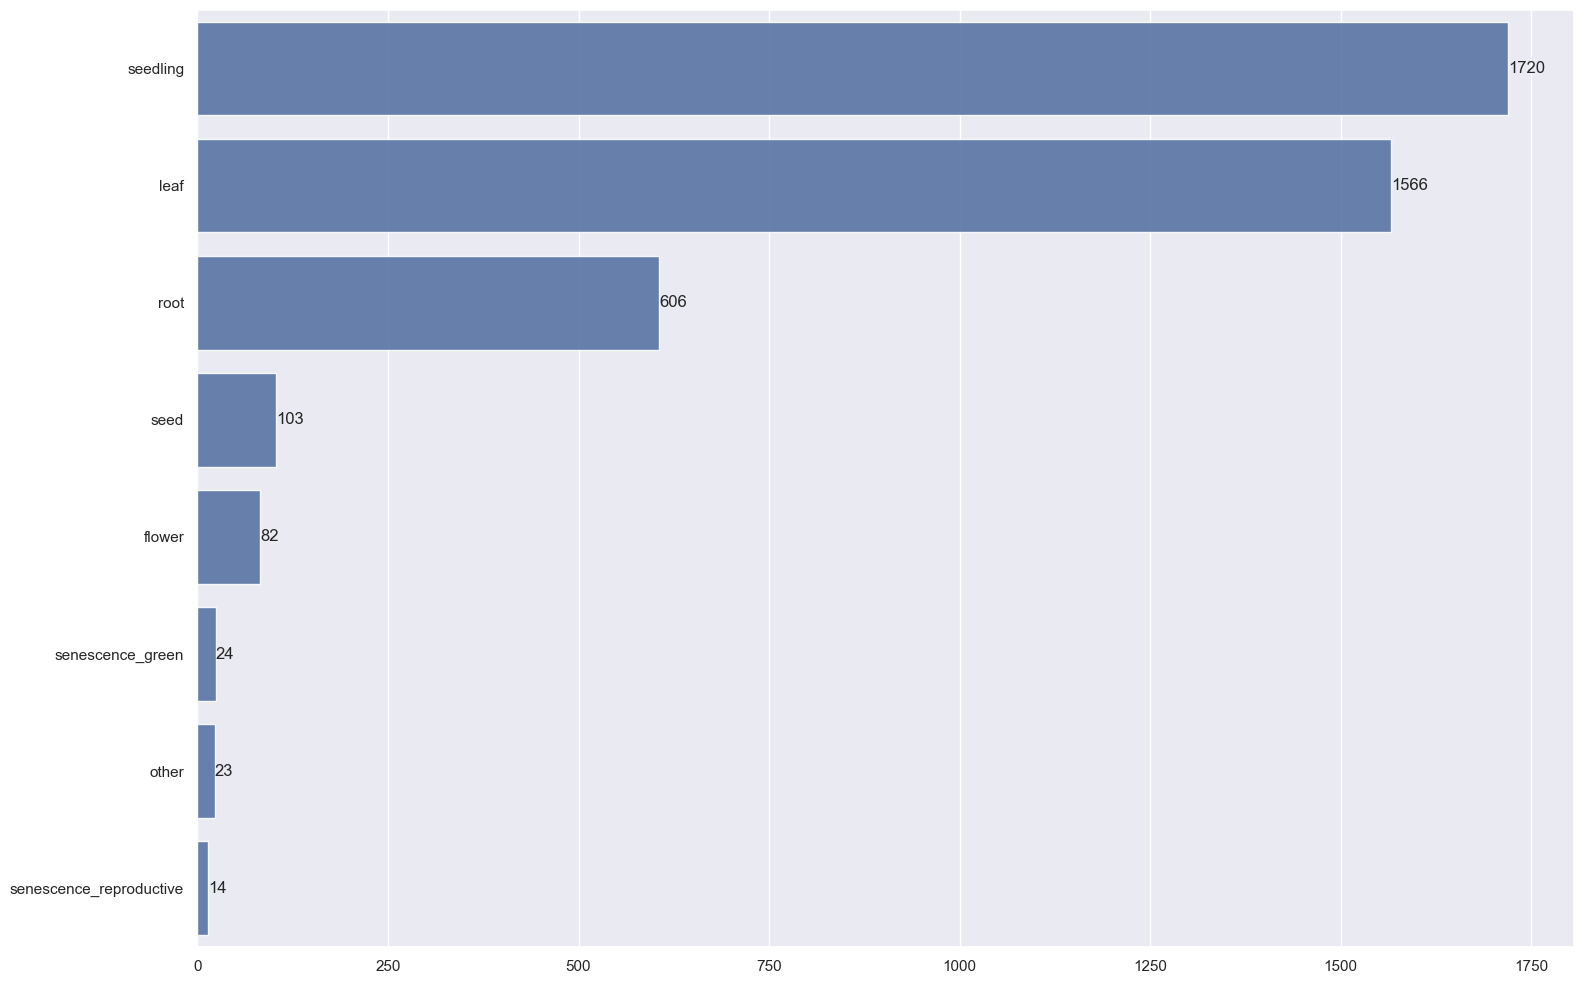

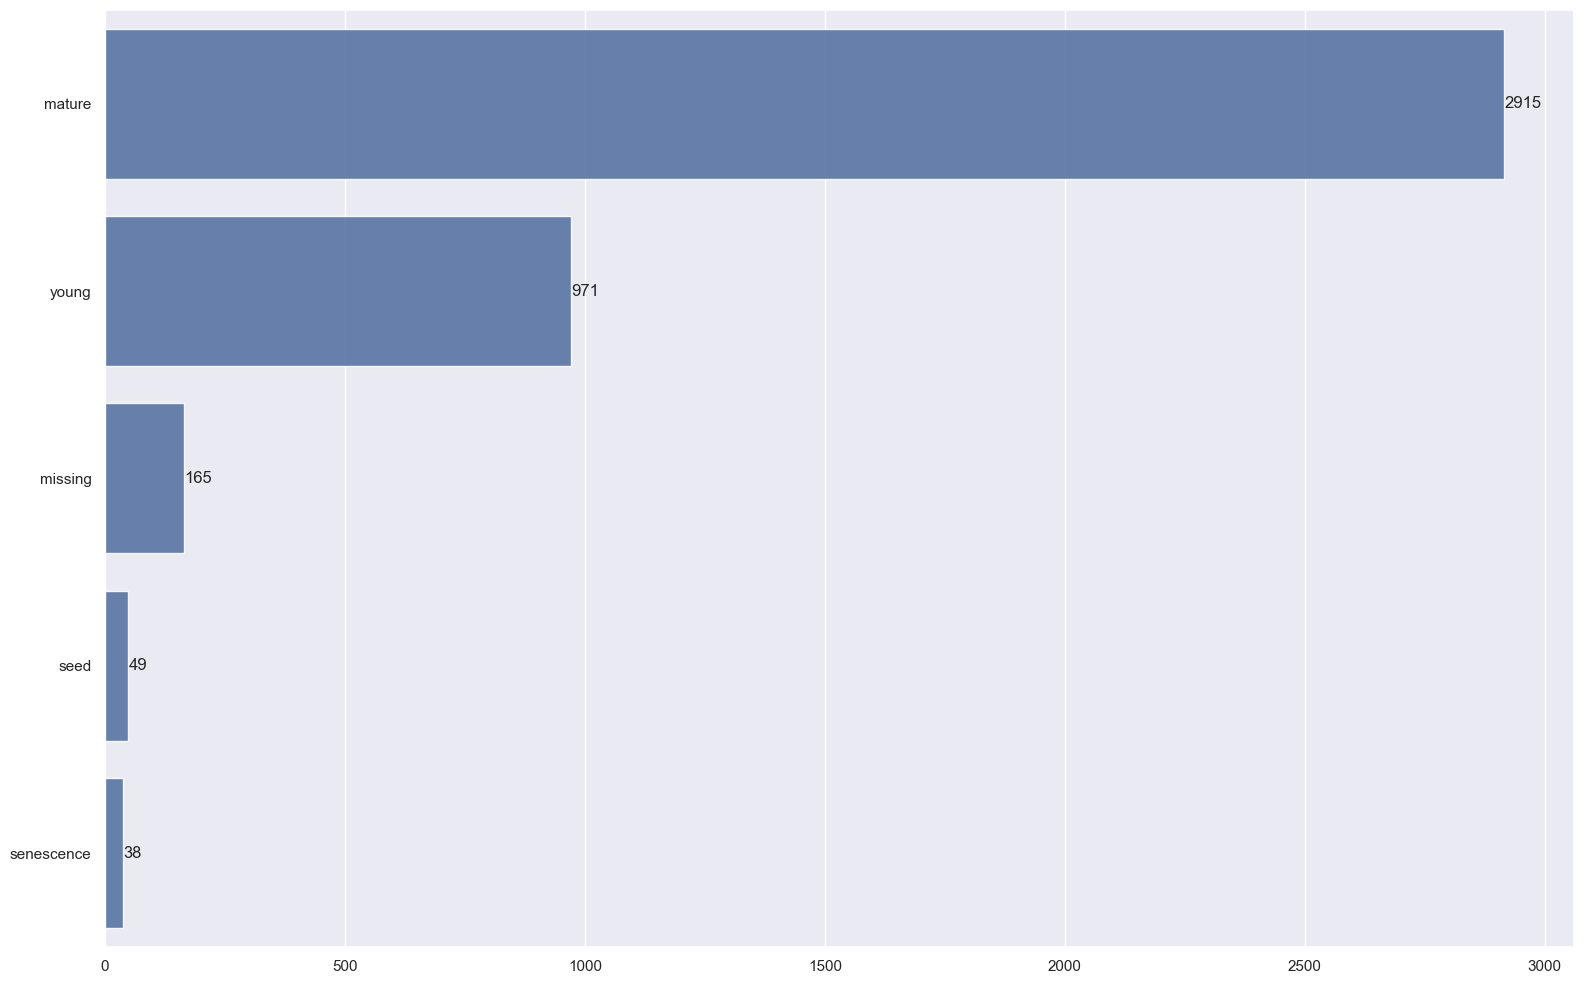

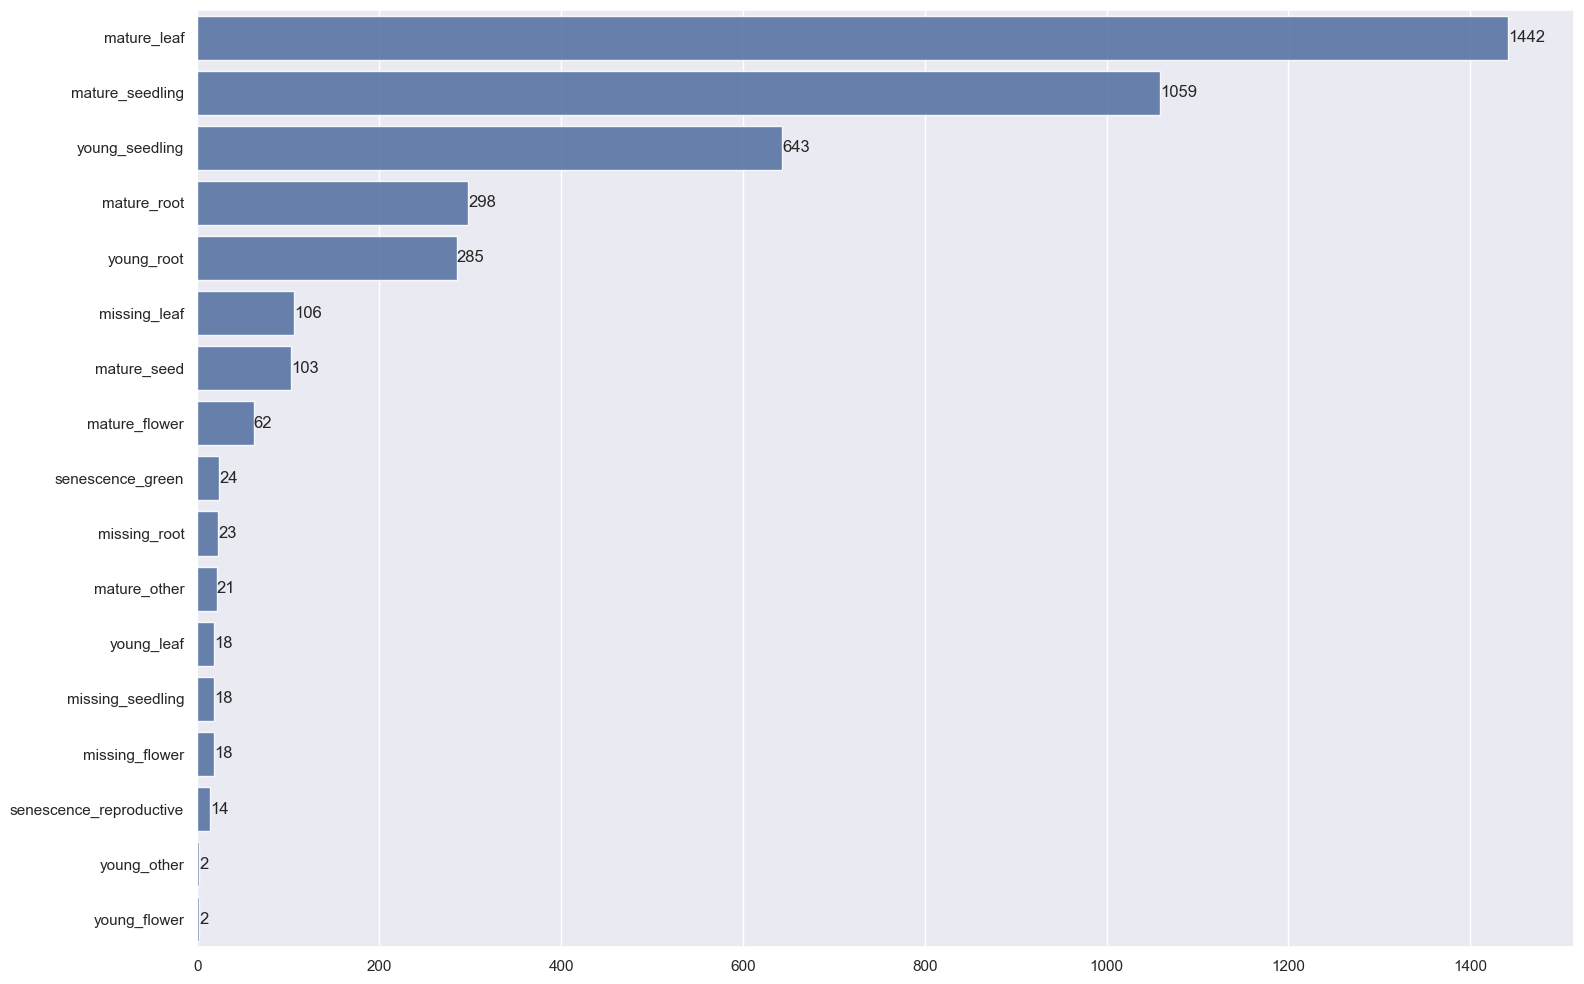

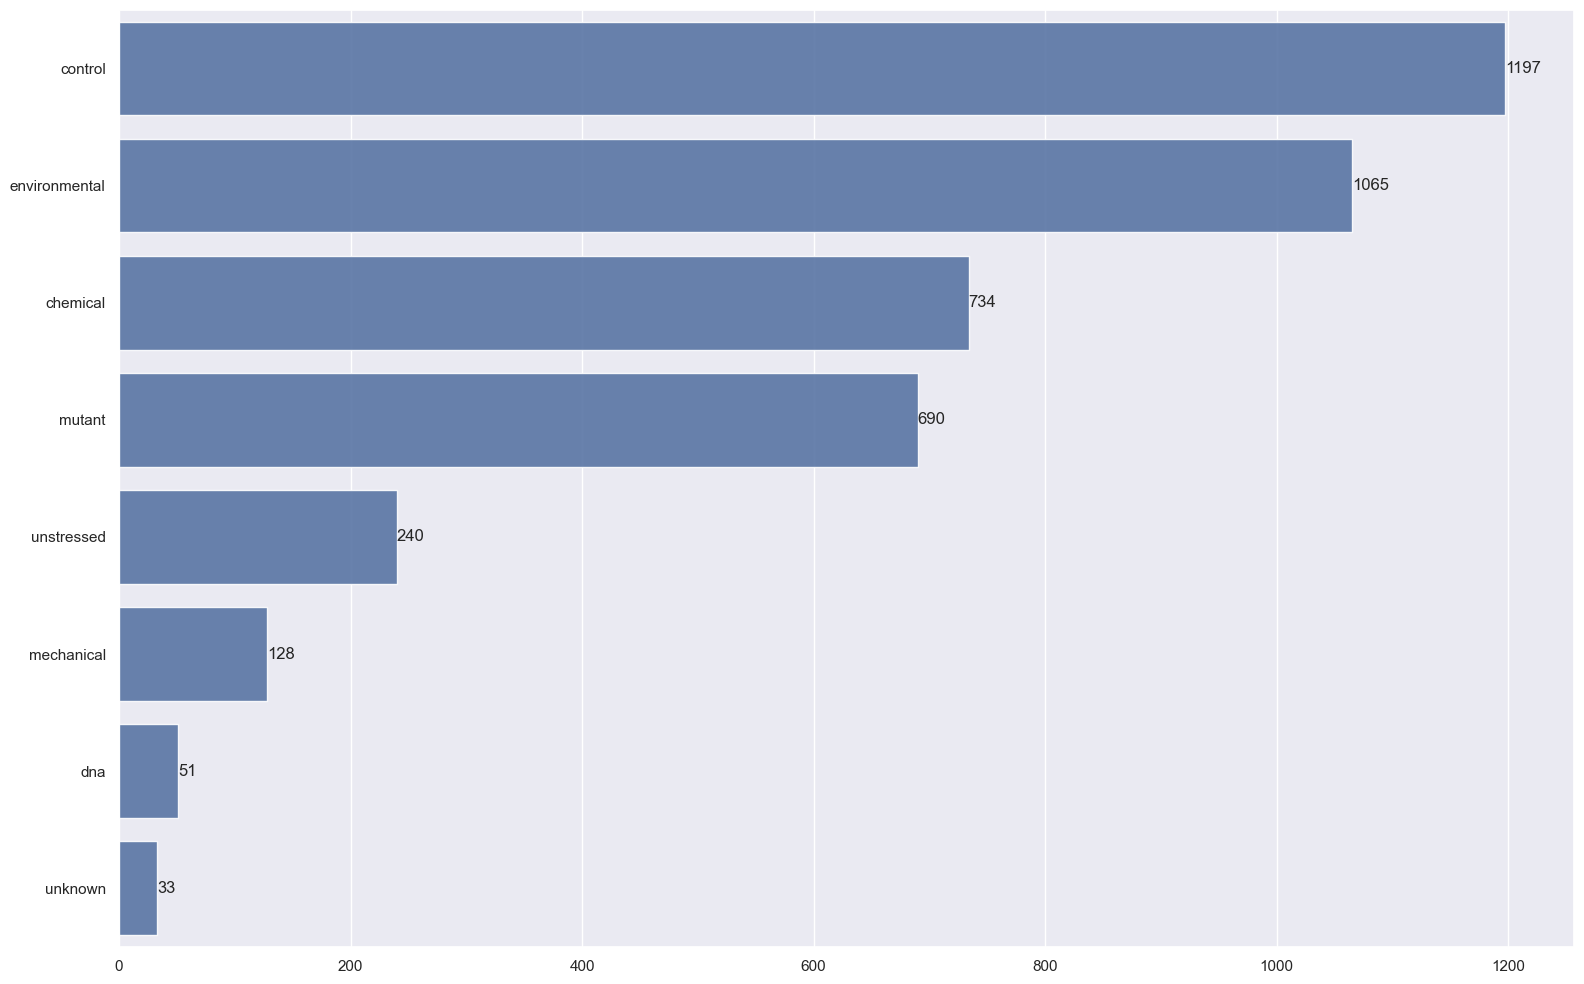

In [27]:
# Display the distribution of groups for all samples

for group in ['tissue', 'age', 'group', 'perturbation'] :
	analysis_metadata.distribution_barplot(
		data     = tissue_metadata,
		group    = group.capitalize(),
		filename = os.path.join(OUT_PLOT, 'distribution-' + group)
	)

	matplotlib.pyplot.show()

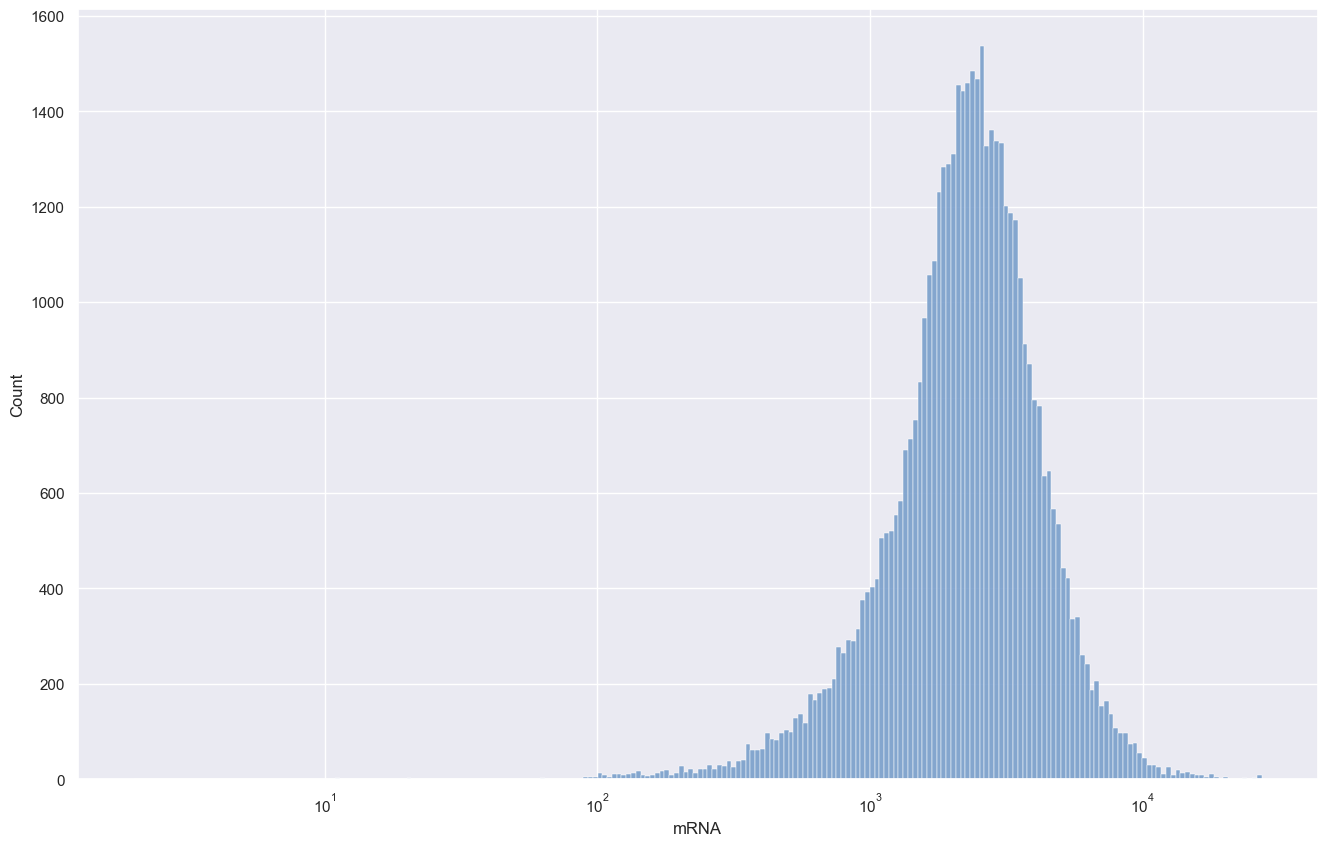

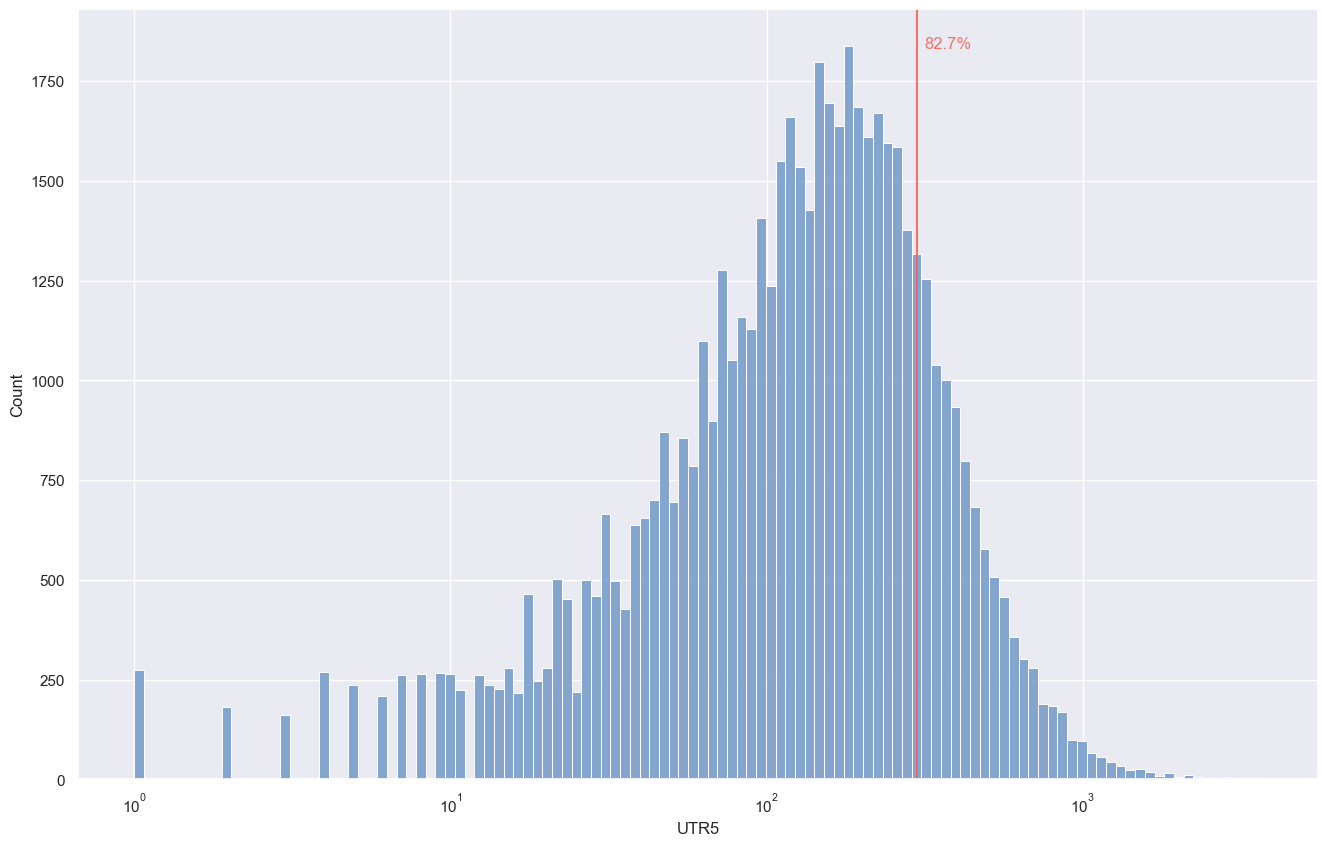

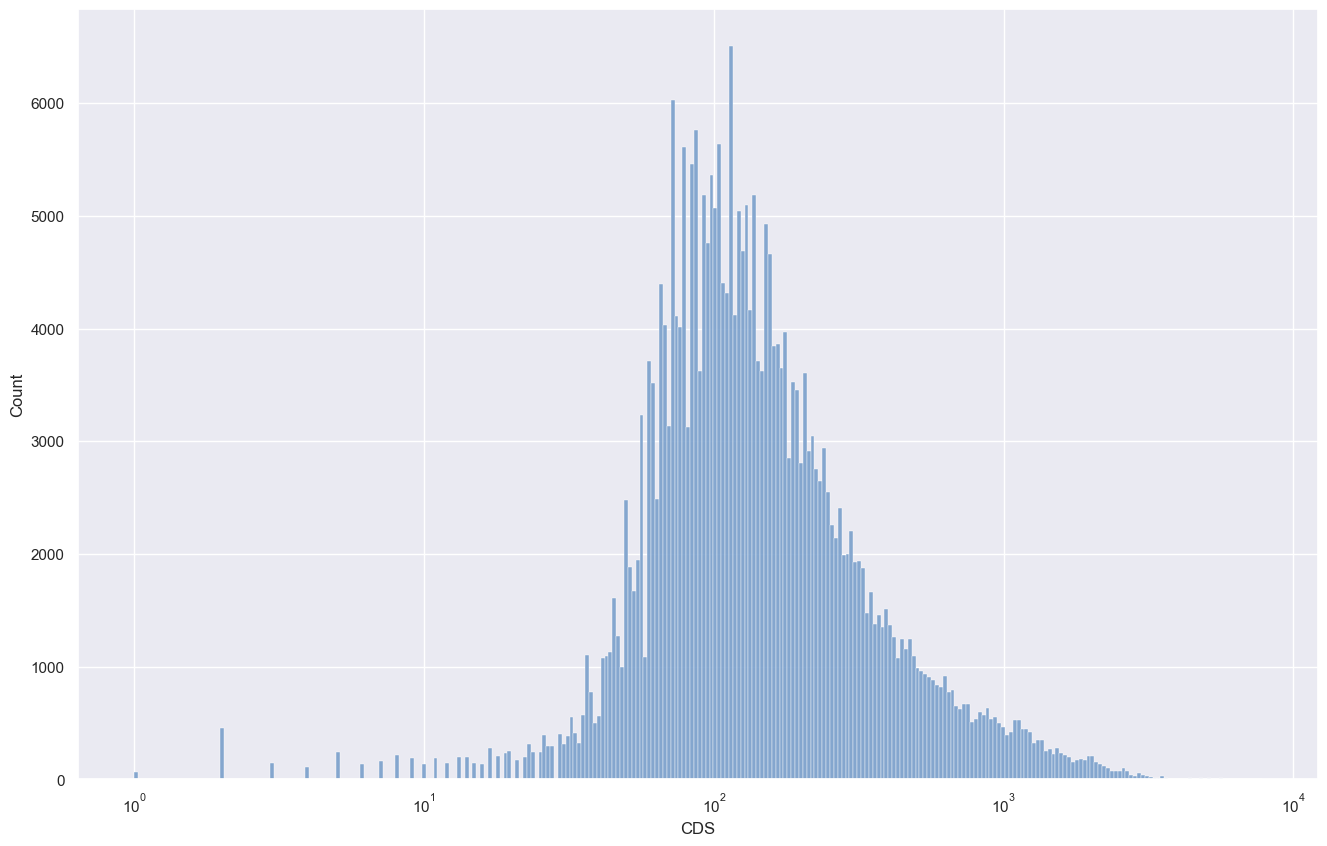

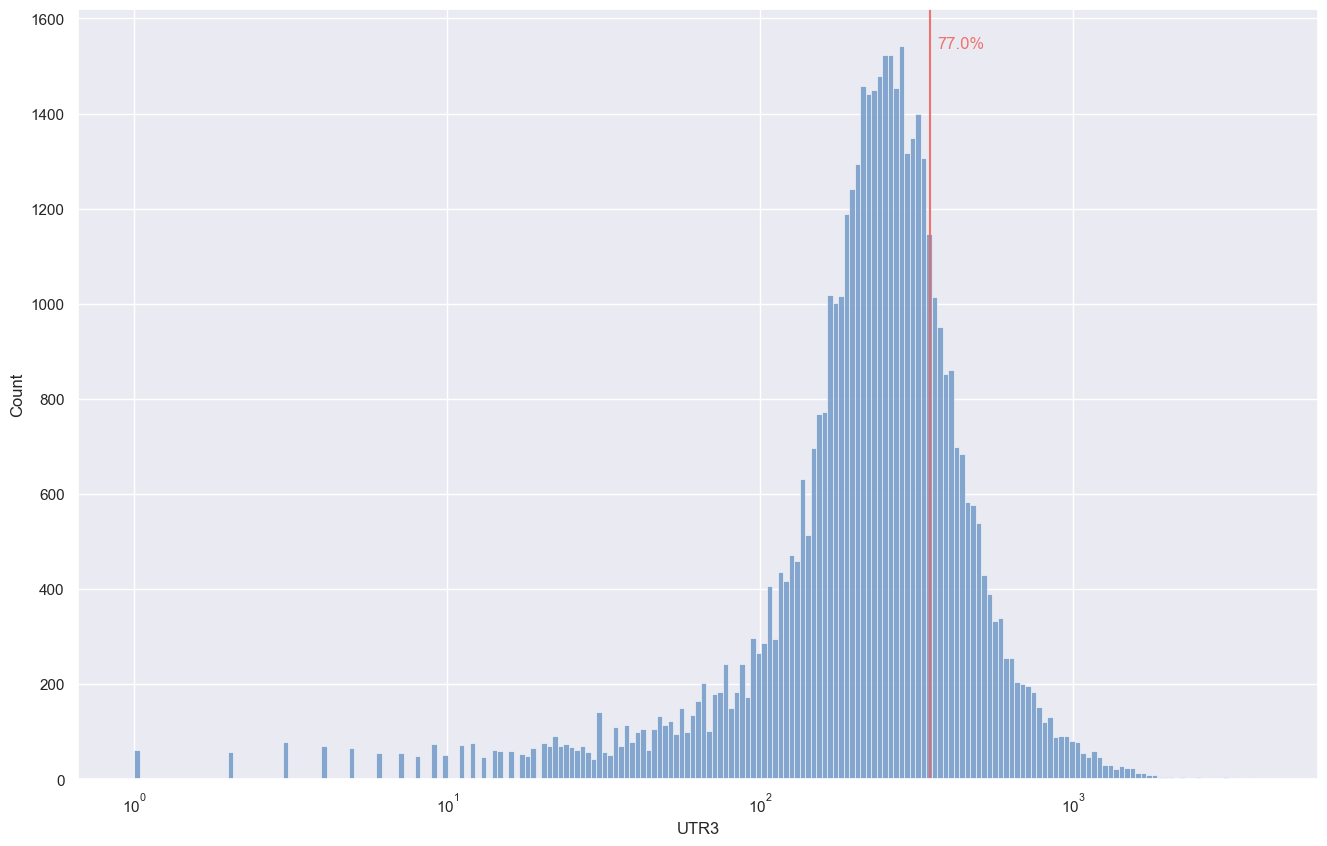

In [28]:
# Display the region length distributions per each region

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = gene_annotation,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-region-' + group.lower())
		)

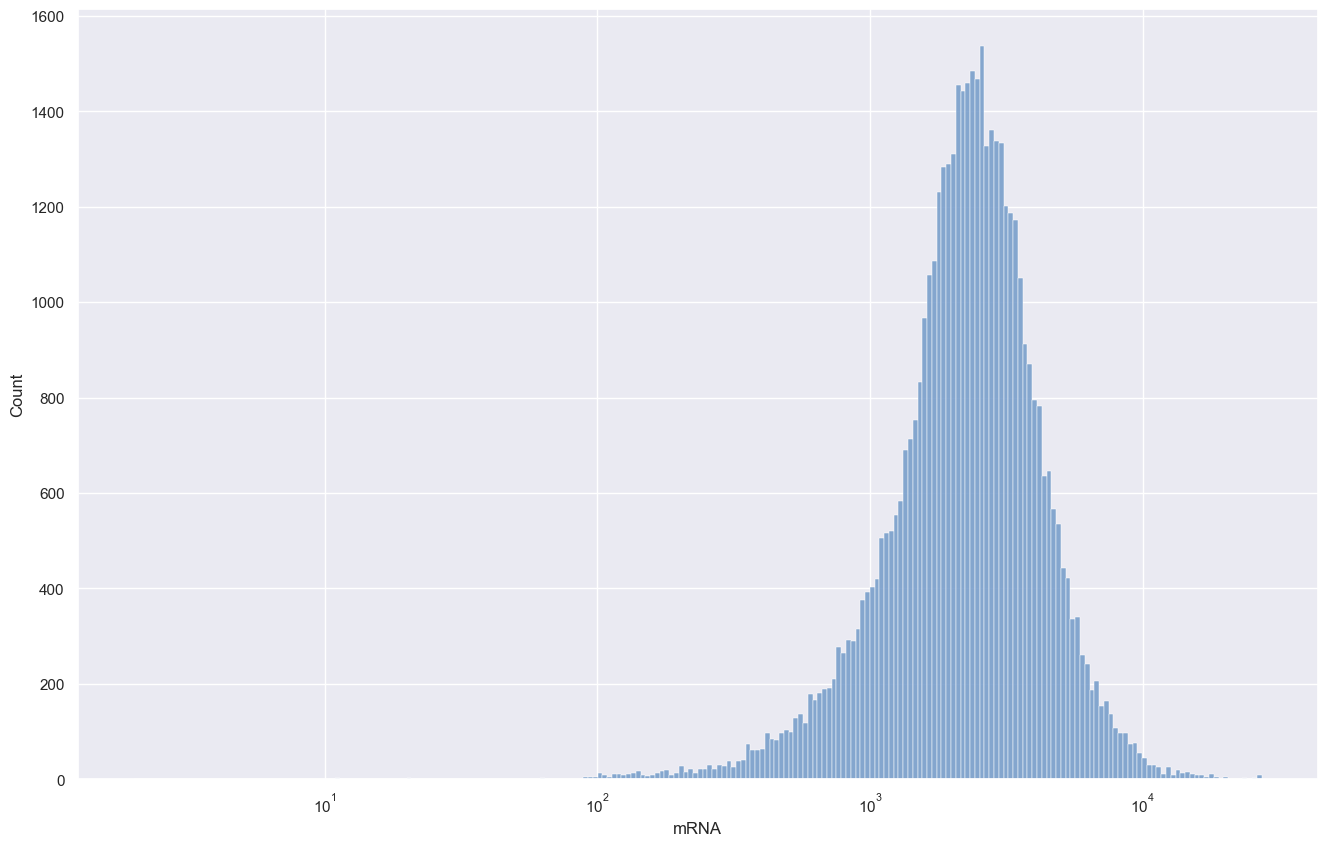

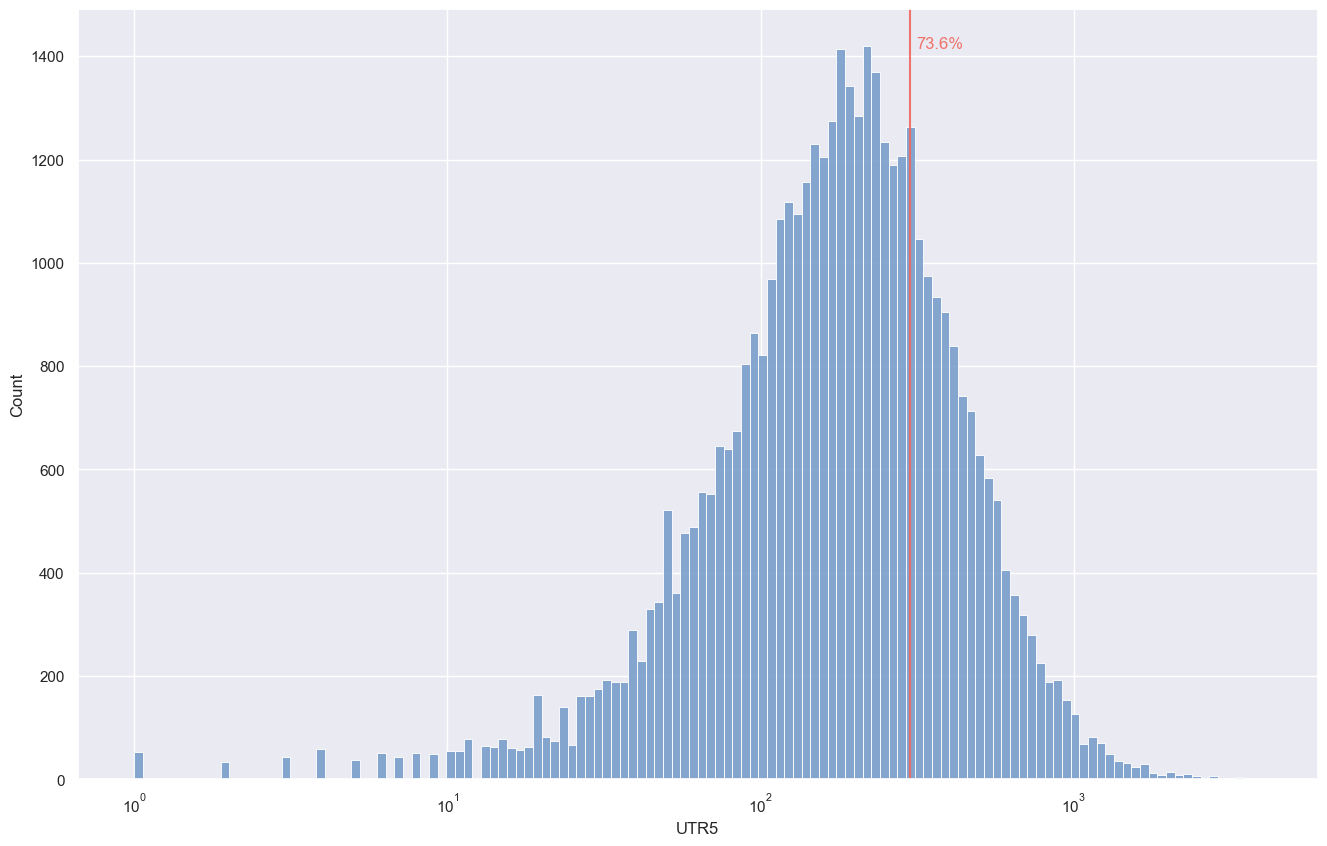

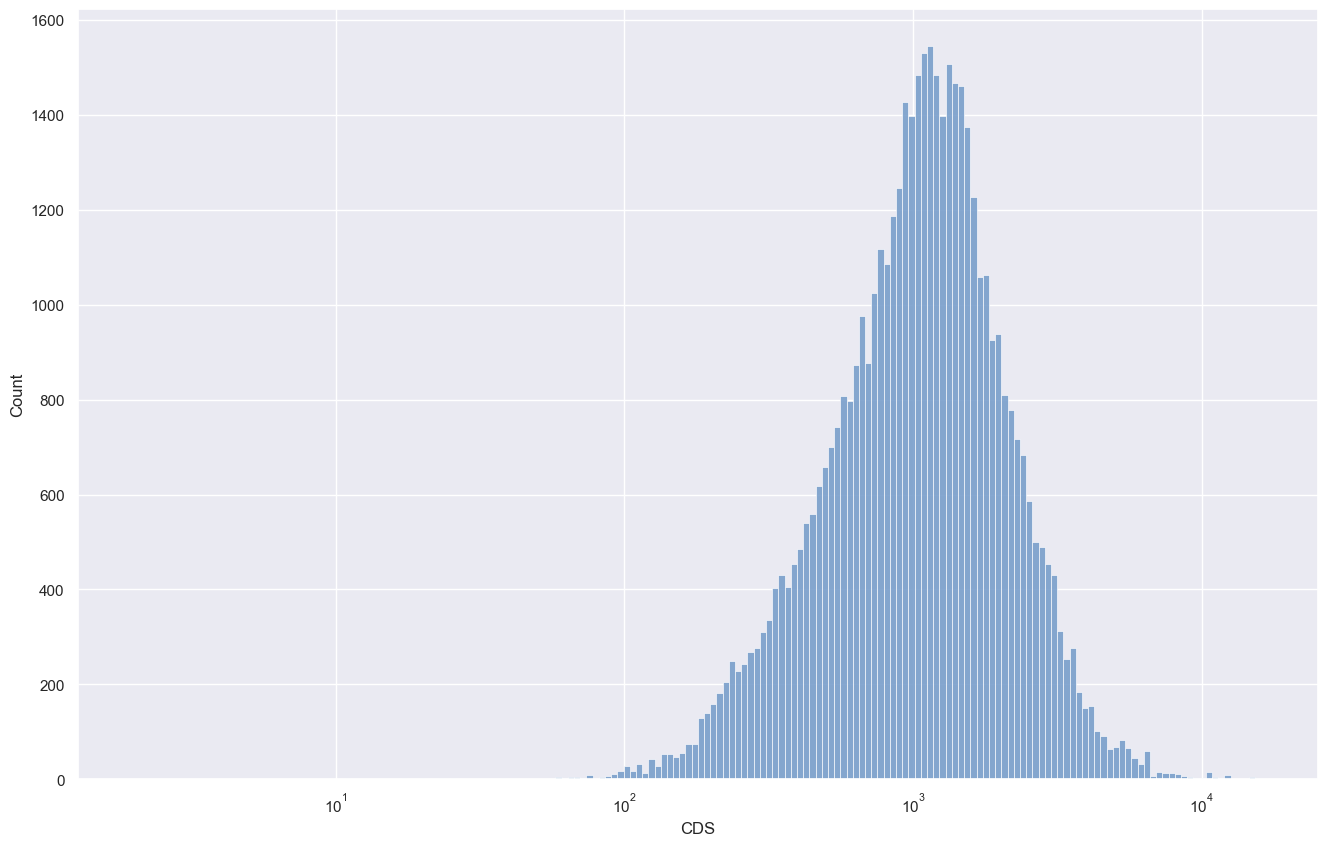

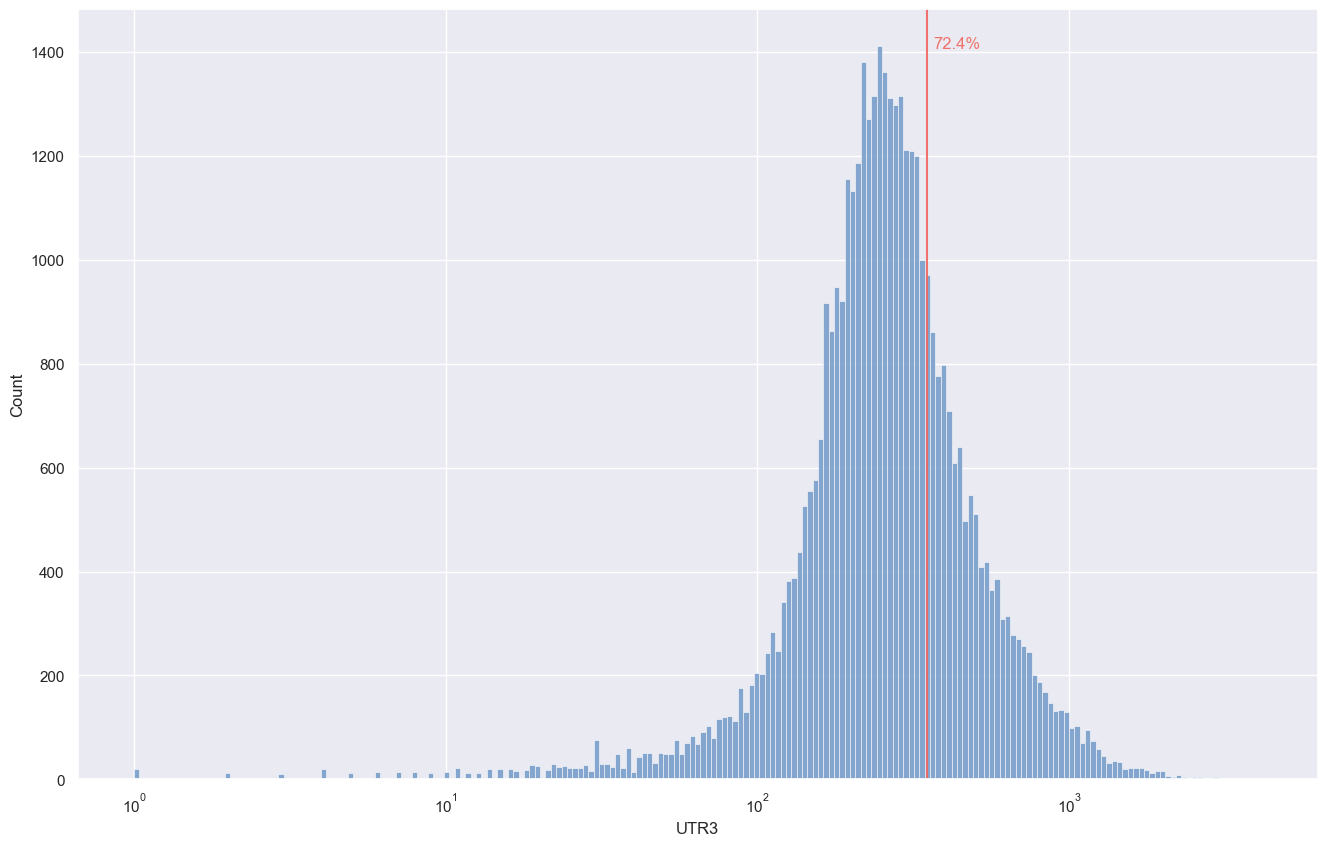

In [29]:
# Display the region length distributions per each region (grouped regions)

dataframe = analysis_annotation.group_regions(
	data    = gene_annotation,
	groupby = 'Transcript',
	regions = ['mRNA', 'UTR5', 'CDS', 'UTR3']
)

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	for group, vline in zip(['mRNA', 'UTR5', 'CDS', 'UTR3'], [0, 300, 0, 350]) :
		analysis_annotation.length_histplot(
			data     = dataframe,
			value    = group,
			vline    = vline,
			filename = os.path.join(OUT_PLOT, 'length-transcript-' + group.lower())
		)

# 5. Groups

In [30]:
# Get the samples per tissue

samples_tissue = dict()

for group in tissue_metadata['Tissue'].unique() :
	samples_tissue[group] = tissue_metadata[tissue_metadata['Tissue'] == group]['Sample'].tolist()

for group in tissue_metadata['Group'].unique() :
	samples_tissue[group] = tissue_metadata[tissue_metadata['Group'] == group]['Sample'].tolist()

# 6. Statistics

In [31]:
# Define transcripts

transcripts = tissue_tpm.iloc[:, 0 ].values

In [32]:
# Compute basic statistics

dataframes = [
	analysis_statistics.generate_basic_statistics(
		data       = tissue_tpm[samples_tissue[tissue]],
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.generate_basic_statistics(
		data       = tissue_tpm,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_basic = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_basic.xs('AT1G01010.1', level = 0)

,Count,Mean,Median,St. Deviation,Variance,Minimum,Maximum,Range,MAD
Tissue,,,,,,,,,
Seedling,1719,10.496,8.013,9.679,93.677,0.001,103.324,103.323,3.491
Seed,102,7.109,4.877,8.883,78.916,0.359,61.140,60.780,1.633
Leaf,1565,5.918,3.506,7.922,62.766,0.001,89.863,89.862,1.889
Root,605,26.687,26.008,16.548,273.846,0.938,130.383,129.445,7.709
Flower,81,6.646,5.379,3.834,14.696,2.385,23.810,21.425,1.542
Other,22,5.243,2.958,5.441,29.600,0.266,21.868,21.602,2.643
Senescence_Reproductive,13,0.453,0.302,0.581,0.337,0.001,2.265,2.264,0.254
Senescence_Green,23,13.756,11.910,14.890,221.712,0.001,60.184,60.183,7.716
Mature_Seedling,1058,9.353,7.693,7.815,61.070,0.338,95.820,95.482,3.361


In [33]:
# Compute advance statistics

dataframes = [
	analysis_statistics.genearte_advance_statistics(
		data       = tissue_tpm[samples_tissue[tissue]],
		transcript = transcripts,
		tissue     = tissue,
		axis       = 1
	)

	for tissue in samples_tissue.keys()
]

dataframes.append(
	analysis_statistics.genearte_advance_statistics(
		data       = tissue_tpm,
		transcript = transcripts,
		tissue     = 'Global',
		axis       = 1
	)
)

statistic_advance = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_advance.xs('AT1G01010.1', level = 0)

,ZScore-Lower,ZScore-Upper,ZScore-Percent,IQR-Lower,IQR-Upper,IQR-Percent
Tissue,,,,,,
Seedling,-18.540,39.532,0.982,-6.415,23.954,0.933
Seed,-19.542,33.759,0.961,-1.599,11.491,0.892
Leaf,-17.849,29.686,0.975,-4.842,13.269,0.904
Root,-22.958,76.332,0.985,-6.458,56.000,0.957
Flower,-4.855,18.147,0.975,-1.292,12.768,0.901
Other,-11.079,21.565,0.955,-8.575,17.180,0.955
Senescence_Reproductive,-1.289,2.196,0.923,-0.799,1.334,0.923
Senescence_Green,-30.914,58.425,0.957,-18.262,36.841,0.913
Mature_Seedling,-14.091,32.798,0.987,-5.845,22.351,0.965


In [34]:
# Compute normality statistics

with warnings.catch_warnings() :
	warnings.simplefilter('ignore')

	dataframes = [
		analysis_statistics.generate_normality_statistics(
			data       = tissue_tpm[samples_tissue[tissue]],
			transcript = transcripts,
			tissue     = tissue
		)

		for tissue in samples_tissue.keys()
	]

	dataframes.append(
		analysis_statistics.generate_normality_statistics(
			data       = tissue_tpm,
			transcript = transcripts,
			tissue     = 'Global'
		)
	)

statistic_normality = pandas.concat(dataframes).set_index(['Transcript', 'Tissue'])
statistic_normality.xs('AT1G01010.1', level = 0)

,Shapiro-Statistic,Shapiro-pValue,NormalTest-Statistic,NormalTest-pValue,Anderson-Statistic,Anderson-CriticalValue,Anderson-Significance
Tissue,,,,,,,
Seedling,0.699,0.000,1367.056,0.000,108.910,1.089,1.000
Seed,0.533,0.000,111.406,0.000,15.584,1.053,1.000
Leaf,0.586,0.000,1407.553,0.000,173.163,1.089,1.000
Root,0.906,0.000,202.582,0.000,9.791,1.085,1.000
Flower,0.800,0.000,46.336,0.000,4.765,1.044,1.000
Other,0.823,0.001,12.664,0.002,1.253,0.966,1.000
Senescence_Reproductive,0.700,0.001,22.457,0.000,1.344,0.942,1.000
Senescence_Green,0.768,0.000,19.280,0.000,1.656,0.969,1.000
Mature_Seedling,0.717,0.000,951.194,0.000,47.771,1.088,1.000


# 7. Save

In [35]:
# Save the updated and synchronized tables

writer.write_csv(
	data         = tissue_metadata,
	filename     = os.path.join(OUT_DATA, 'tissue-metadata.csv'),
	write_index  = False
)

writer.write_csv(
	data        = tissue_tpm,
	filename    = os.path.join(OUT_DATA, 'tissue-tpm.csv'),
	write_index = False
)

writer.write_csv(
	data        = gene_annotation,
	filename    = os.path.join(OUT_DATA, 'gene-annotation.csv'),
	write_index = False
)

writer.write_csv(
	data        = statistic_basic,
	filename    = os.path.join(OUT_DATA, 'statistics-basic.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_advance,
	filename    = os.path.join(OUT_DATA, 'statistics-advance.csv'),
	write_index = True
)

writer.write_csv(
	data        = statistic_normality,
	filename    = os.path.join(OUT_DATA, 'statistics-normality.csv'),
	write_index = True
)